In [53]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math


USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

In [54]:
import pandas as pd

df = pd.read_csv('drive/My Drive/dataset/DailyDialog/train.csv', header=None)
df_val = pd.read_csv('drive/My Drive/dataset/DailyDialog/validation.csv', header=None)
df_test = pd.read_csv('drive/My Drive/dataset/DailyDialog/test.csv', header=None)

In [55]:
inp = df[0].to_list()
opt = df[1].to_list()
inp_val = df_val[0].to_list()
opt_val = df_val[1].to_list()
inp_test = df_test[0].to_list()
opt_test = df_test[1].to_list()

In [56]:
pairs = []
for i, o in zip(inp, opt):
  pairs.append([i,o])
pairs_val = []
for i, o in zip(inp_val, opt_val):
  pairs_val.append([i,o])
pairs_test = []
for i, o in zip(inp_test, opt_test):
  pairs_test.append([i,o])

In [57]:
len(pairs)

54076

In [58]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token
UNK_token = 3

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS", UNK_token:"UNK"}
        self.num_words = 4  # Count SOS, EOS, PAD, UNK

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    #単語を辞書に追加する
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # 低頻出wordを削除する
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS", UNK_token:"UNK"}
        self.num_words = 4 # Count default tokens

        for word in keep_words:
            self.addWord(word)

In [59]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# Read query/response pairs and return a voc object
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs

# Returns True iff both sentences in a pair 'p' are under the MAX_LENGTH threshold
def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Filter pairs using filterPair condition
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Using the functions defined above, return a populated voc object and pairs list
def loadPrepareData(corpus, corpus_name, datafile, save_dir):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs

"""
# Load/Assemble voc and pairs
save_dir = os.path.join("data", "save")
voc, pairs = loadPrepareData(corpus, corpus_name, datafile, save_dir)
# Print some pairs to validate
print("\npairs:")
print(len(pairs))
for pair in pairs[:10]:
    print(pair)
"""

'\n# Load/Assemble voc and pairs\nsave_dir = os.path.join("data", "save")\nvoc, pairs = loadPrepareData(corpus, corpus_name, datafile, save_dir)\n# Print some pairs to validate\nprint("\npairs:")\nprint(len(pairs))\nfor pair in pairs[:10]:\n    print(pair)\n'

In [60]:
def loadPrepareData(pairs, corpus_name):
    print("Start preparing training data ...")
    voc = Voc(corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs

corpus_name = "daily_dialog"
voc, pairs = loadPrepareData(pairs, 'daily_dialog')

Start preparing training data ...
Read 54076 sentence pairs
Trimmed to 54076 sentence pairs
Counting words...
Counted words: 19901


In [61]:
MIN_COUNT = 3    # MIN_COUNTより少ない登場回数は消す
MAX_LENGTH = 30

def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs


# Trim voc and pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 10930 / 19897 = 0.5493
Trimmed from 54076 pairs to 43208, 0.7990 of total


In [62]:
#word2index
def indexesFromSentence(voc, sentence):
    #return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]
    return [voc.word2index[word] if word in voc.word2index else UNK_token for word in sentence.split(' ')] + [EOS_token]

#[i if i % 2 == 0 else "odd" for i in range(10)]

def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(False)
            else:
                m[i].append(True)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


# Example for validation
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

"""
print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)
"""

'\nprint("input_variable:", input_variable)\nprint("lengths:", lengths)\nprint("target_variable:", target_variable)\nprint("mask:", mask)\nprint("max_target_len:", max_target_len)\n'

In [63]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    # (10, 64), (64)
    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        #print("embedded", embedded.shape)
        # データの系列長を固定する
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        #print("packed", packed.shape)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        #print("outputs", outputs.shape)
        #print("hn", hidden[0].shape)
        #print("cn", hidden[1].shape)
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        #print("outputs", outputs.shape)
        # Sum bidirectional GRU outputs
        # 前方向の隠れ状態と、後ろ方向の隠れ状態を足している
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        #print("outputs", outputs.shape)
        # Return output and final hidden state
        return outputs, hidden

In [64]:
# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [65]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

In [66]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

In [67]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):
  
    encoder.train()
    decoder.train()

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device) #(64, 10)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

In [81]:
def val(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          batch_size, max_length=MAX_LENGTH):

    encoder.eval()
    decoder.eval()

    # Set device options
    input_variable = input_variable.to(device) #(64, 10)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    return sum(print_losses) / n_totals

In [98]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, 
               encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, 
               corpus_name, loadFilename):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]
    training_batches_val = [batch2TrainData(voc, [random.choice(pairs_val) for _ in range(batch_size)])
                      for _ in range(n_iteration)] 

    # Initializations
    print('Initializing ...')
    result = []
    result_val = []
    start_iteration = 1
    print_loss = 0
    print_loss_val = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        training_batch_val = training_batches_val[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch #(10, 64), (64), (10, 64), (10, 64)
        input_variable_val, lengths_val, target_variable_val, mask_val, max_target_len_val = training_batch_val

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        ###ここで評価データ
        
        loss_val = val(input_variable_val, lengths_val, target_variable_val, mask_val, max_target_len_val, encoder,
                     decoder, embedding, batch_size)
        print_loss_val += loss_val

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print_loss_avg_val = print_loss_val / print_every
            result.append(print_loss_avg)
            result_val.append(print_loss_avg_val)
            print("Iteration_tra: {}; Percent complete: {:.1f}%; Average loss: {:.4f}; ppl: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg, math.exp(print_loss_avg) ))
            print("Iteration_val: {}; Percent complete: {:.1f}%; Average loss: {:.4f}; ppl: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg_val, math.exp(print_loss_avg_val) ))
            print_loss = 0
            print_loss_val = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

    return result, result_val

In [99]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

In [100]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

In [101]:
# Configure models
model_name = 'cb_model'
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 4000
#loadFilename = os.path.join(save_dir, model_name, corpus_name,
#                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
#                            '{}_checkpoint.tar'.format(checkpoint_iter))


# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


In [102]:
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 4000
print_every = 1
save_every = 500

save_dir = "/content/drive/My Drive/dataset/DailyDialog"
corpus_name = "daily_dialog"

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# Run training iterations
print("Starting Training!")

loss, loss_val = trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)


ストリーミング出力は最後の 5000 行に切り捨てられました。
Iteration_val: 1501; Percent complete: 37.5%; Average loss: 4.2428; ppl: 69.6049
Iteration_tra: 1502; Percent complete: 37.5%; Average loss: 3.8714; ppl: 48.0092
Iteration_val: 1502; Percent complete: 37.5%; Average loss: 4.2426; ppl: 69.5887
Iteration_tra: 1503; Percent complete: 37.6%; Average loss: 3.7924; ppl: 44.3616
Iteration_val: 1503; Percent complete: 37.6%; Average loss: 4.4887; ppl: 89.0021
Iteration_tra: 1504; Percent complete: 37.6%; Average loss: 3.8194; ppl: 45.5777
Iteration_val: 1504; Percent complete: 37.6%; Average loss: 4.4863; ppl: 88.7922
Iteration_tra: 1505; Percent complete: 37.6%; Average loss: 3.6290; ppl: 37.6751
Iteration_val: 1505; Percent complete: 37.6%; Average loss: 4.3857; ppl: 80.2974
Iteration_tra: 1506; Percent complete: 37.6%; Average loss: 3.5799; ppl: 35.8705
Iteration_val: 1506; Percent complete: 37.6%; Average loss: 4.2707; ppl: 71.5739
Iteration_tra: 1507; Percent complete: 37.7%; Average loss: 3.5387; ppl: 34.4

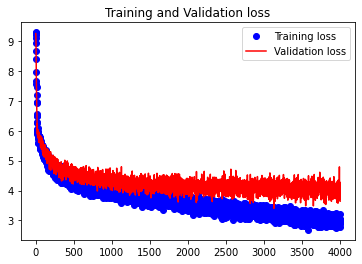

In [111]:
import matplotlib.pyplot as plt
import numpy as np

epochs = range(1, n_iteration+1)

plt.plot(epochs, loss, 'bo',  label='Training loss')
plt.plot(epochs, loss_val, 'b', color='red', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, searcher, voc)

In [ ]:
"""
import pickle

model_path = '/content/drive/My Drive/dataset/DailyDialog/chatbot_encoder0714.pth'
torch.save(encoder.to('cpu').state_dict(), model_path)
model_path = '/content/drive/My Drive/dataset/DailyDialog/chatbot_decoder0714.pth'
torch.save(decoder.to('cpu').state_dict(), model_path)

with open('/content/drive/My Drive/dataset/DailyDialog/voc_word2index0714.pkl', 'wb') as f:
    pickle.dump(voc.word2index, f)
with open('/content/drive/My Drive/dataset/DailyDialog/voc_index2word.pkl', 'wb') as f:
    pickle.dump(voc.index2word, f)
"""